In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, PReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

classes_to_keep = [0, 1, 2, 3, 4]
train_mask = np.isin(y_train_full, classes_to_keep)
test_mask = np.isin(y_test, classes_to_keep)

X_train_filtered = X_train_full[train_mask]
y_train_filtered = y_train_full[train_mask]
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

X_valid, X_train = X_train_filtered[:2500], X_train_filtered[2500:]
y_valid, y_train = y_train_filtered[:2500], y_train_filtered[2500:]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

base_model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, kernel_initializer='he_normal'),
    PReLU(),
    Dense(100, kernel_initializer='he_normal'),
    PReLU(),
    Dense(5, activation='softmax')
])

In [ ]:
base_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.0001)

base_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

base_model.save('my_model.h5')

## MNIST Fashion

In [ ]:
(X_train_fm, y_train_fm), (X_test_fm, y_test_fm) = keras.datasets.fashion_mnist.load_data()
X_train_fm = X_train_fm / 255.0
X_test_fm = X_test_fm / 255.0

X_valid_fm, X_train_fm = X_train_fm[:2500], X_train_fm[2500:]
y_valid_fm, y_train_fm = y_train_fm[:2500], y_train_fm[2500:]

mean_image = np.mean(X_train_fm, axis=0)
X_train_fm -= mean_image
X_valid_fm -= mean_image
X_test_fm -= mean_image

In [ ]:
pretrained = keras.models.load_model('my_model.h5')
pretrained.summary()

In [ ]:
input_layer = Input(shape=(28, 28))
x = Flatten()(input_layer)
x = Dense(300, kernel_initializer='he_normal')(x)
x = PReLU()(x)
x = Dense(100, kernel_initializer='he_normal')(x)
x = PReLU()(x)

In [ ]:
temp_model = Model(inputs=input_layer, outputs=x)
for i in range(4):
    temp_model.layers[i + 1].set_weights(pretrained.layers[i + 1].get_weights())
    temp_model.layers[i + 1].trainable = False

output_layer = Dense(10, activation='softmax')(x)
final_model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
final_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.fit(
    X_train_fm, y_train_fm,
    epochs=20,
    batch_size=64,
    validation_data=(X_valid_fm, y_valid_fm),
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_acc = final_model.evaluate(X_test_fm, y_test_fm)
print(f"Test accuracy on Fashion-MNIST: {test_acc:.4f}")

#New model

In [ ]:
from google.colab import drive
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
drive.mount('/content/drive')

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
LIMIT_SAMPLES = 14032
EPOCHS_STAGE_1 = 10
EPOCHS_STAGE_2 = 5
MODEL_DIR = '/content/drive/MyDrive/saved_models'
MODEL_PATH = os.path.join(MODEL_DIR, 'final_model.keras')
#!cp -r /content/drive/MyDrive/intel-image-classification-cnn/seg_train /content/data
DATASET_DIR = '/content/data/seg_train'
#DATASET_DIR = '/content/drive/MyDrive/intel-image-classification-cnn/seg_train/seg_train'
os.makedirs(MODEL_DIR, exist_ok=True)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

def get_dataset(subset):
    generator = datagen.flow_from_directory(
        DATASET_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset=subset,
        shuffle=True,
        seed=0
    )
    class_names = list(generator.class_indices.keys())

    def limited_gen():
        count = 0
        for x, y in generator:
            try:
                yield x, y
                count += len(x)
                if count >= LIMIT_SAMPLES:
                    break
            except Exception as e:
                print(f"Ошибка при обработке батча: {e}")
                continue

    dataset = tf.data.Dataset.from_generator(
        limited_gen,
        output_signature=(
            tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(class_names)), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)

    return dataset, len(class_names), class_names

train_ds, num_classes, class_names = get_dataset('training')
val_ds, _, _ = get_dataset('validation')

with open(os.path.join(MODEL_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names, f)

def create_model(trainable=False):
    base = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base.trainable = trainable
    return models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

In [3]:
# === Этап 1: Feature Extraction ===
model = create_model(trainable=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_1,
    steps_per_epoch=LIMIT_SAMPLES // BATCH_SIZE,
    callbacks=callbacks
)

# === Этап 2: Fine-Tuning (размораживаем часть слоёв) ===

def unfreeze_last_layers(model, n_layers=40):
    base_model = model.layers[0]
    for layer in base_model.layers[-n_layers:]:
        layer.trainable = True

unfreeze_last_layers(model, n_layers=40)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_2,
    steps_per_epoch=LIMIT_SAMPLES // BATCH_SIZE,
    callbacks=callbacks
)

model.save(MODEL_PATH)
with open(os.path.join(MODEL_DIR, 'history1.pkl'), 'wb') as f:
    pickle.dump(history1.history, f)
with open(os.path.join(MODEL_DIR, 'history2.pkl'), 'wb') as f:
    pickle.dump(history2.history, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Epoch 1/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.7345 - loss: 0.7081
Epoch 1: val_loss improved from inf to 0.31156, saving model to /content/drive/MyDrive/saved_models/best_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


877/877 ━━━━━━━━━━━━━━━━━━━━ 1602s 2s/step - accuracy: 0.7346 - loss: 0.7079 - val_accuracy: 0.8873 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 2/10
  1/877 ━━━━━━━━━━━━━━━━━━━━ 8:07 557ms/step - accuracy: 0.8125 - loss: 0.4156
Epoch 2: val_loss improved from 0.31156 to 0.30986, saving model to /content/drive/MyDrive/saved_models/best_model.keras
877/877 ━━━━━━━━━━━━━━━━━━━━ 734s 837ms/step - accuracy: 0.8125 - loss: 0.4156 - val_accuracy: 0.8869 - val_loss: 0.3099 - learning_rate: 0.0010
Epoch 3/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.8598 - loss: 0.3892
Epoch 3: val_loss improved from 0.30986 to 0.28629, saving model to /content/drive/MyDrive/saved_models/best_model.keras
877/877 ━━━━━━━━━━━━━━━━━━━━ 1445s 2s/step - accuracy: 0.8598 - loss: 0.3892 - val_accuracy: 0.8946 - val_loss: 0.2863 - learning_rate: 0.0010
Epoch 4/10
  1/877 ━━━━━━━━━━━━━━━━━━━━ 8:10 560ms/step - accuracy: 0.9375 - loss: 0.2297
Epoch 4: val_loss improved from 0.28629 to 0.28063, saving 

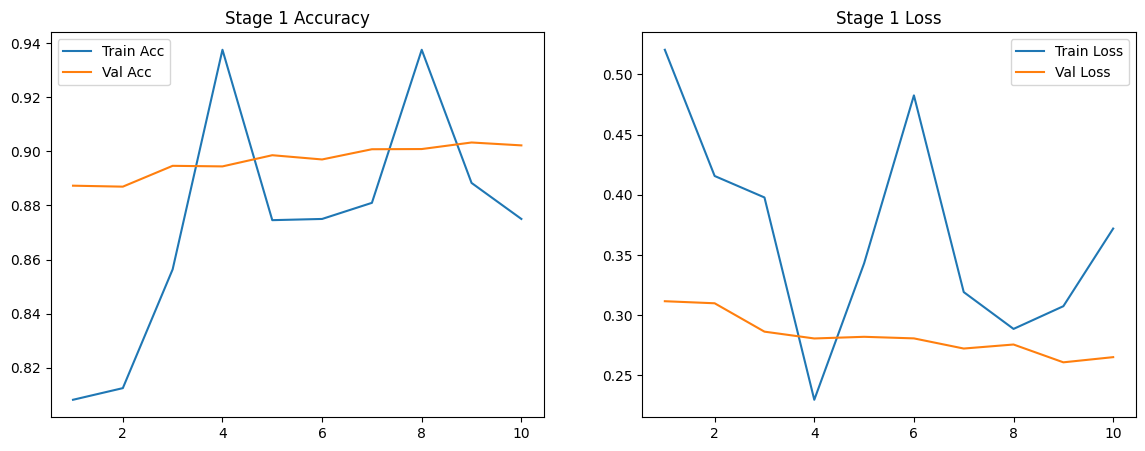

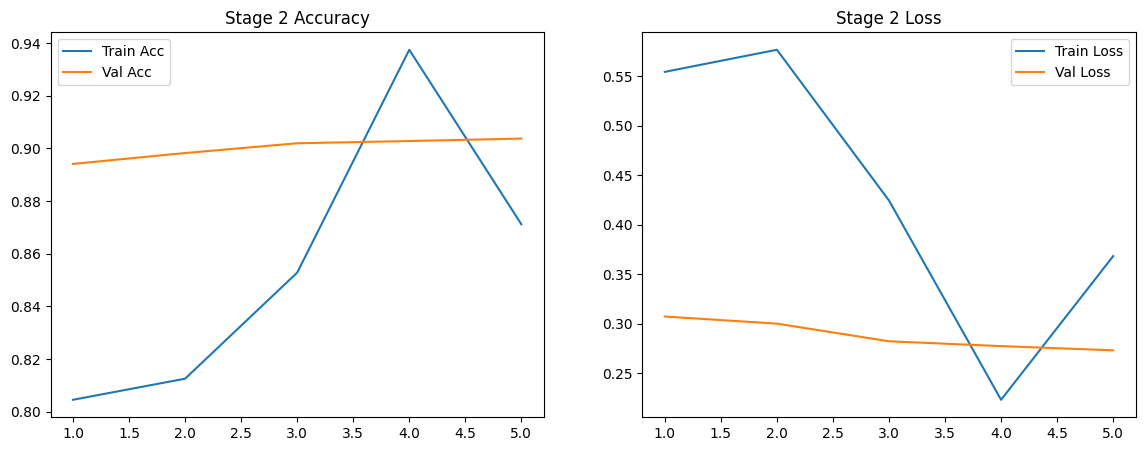

In [4]:
def plot_training_history(history, title=''):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title(title + ' Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(title + ' Loss')
    plt.legend()
    plt.show()

plot_training_history(history1.
history, 'Stage 1')
plot_training_history(history2.history, 'Stage 2')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━

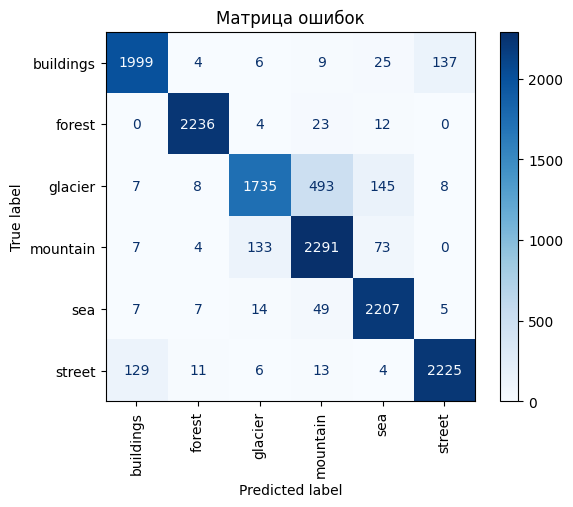

In [5]:
y_true, y_pred = [], []
for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(MODEL_PATH)

# === Вручную создаём feature_extractor на основе Sequential-модели ===
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = inputs
for layer in model.layers[:-2]:  # убираем последние 2 слоя
    x = layer(x)
feature_extractor = tf.keras.Model(inputs=inputs, outputs=x)

# === Индексация эмбеддингов ===
train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

embeddings, paths = [], []
for i in range(min(LIMIT_SAMPLES, len(train_gen.filenames))):
    img_path = os.path.join(DATASET_DIR, train_gen.filenames[i])
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    emb = feature_extractor.predict(img_array, verbose=0)
    embeddings.append(emb[0])
    paths.append(img_path)

# === Сохраняем эмбеддинги ===
with open(os.path.join(MODEL_DIR, 'image_embeddings.pkl'), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'paths': paths}, f)

# === (опционально) Сохраняем сам feature_extractor ===
feature_extractor.save(os.path.join(MODEL_DIR, 'feature_extractor.keras'))

# === Индексация эмбеддингов ===
train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

embeddings, paths = [], []
for i in range(min(LIMIT_SAMPLES, len(train_gen.filenames))):
    img_path = os.path.join(DATASET_DIR, train_gen.filenames[i])
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)
    emb = feature_extractor.predict(img_array, verbose=0)
    embeddings.append(emb[0])
    paths.append(img_path)

with open(os.path.join(MODEL_DIR, 'image_embeddings.pkl'), 'wb') as f:
    pickle.dump({'embeddings': embeddings, 'paths': paths}, f)

Found 14034 images belonging to 6 classes.


In [ ]:
def predict_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)
    confidence = np.max(preds)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Предсказано: {class_names[class_idx]} ({confidence:.2f})")
    plt.show()

def show_similar_images(query_img_path, top_k=5):
    with open(os.path.join(MODEL_DIR, 'image_embeddings.pkl'), 'rb') as f:
        data = pickle.load(f)
    embeddings, paths = np.array(data['embeddings']), data['paths']
    img = image.load_img(query_img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img) / 255.0
    x = tf.expand_dims(x, 0)
    query_emb = feature_extractor.predict(x, verbose=0)
    sims = cosine_similarity(query_emb, embeddings)[0]
    top_idxs = np.argsort(sims)[::-1][:top_k]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_idxs):
        sim_img = image.load_img(paths[idx], target_size=IMG_SIZE)
        plt.subplot(1, top_k, i + 1)
        plt.imshow(sim_img)
        plt.title(f"Сходство: {sims[idx]:.2f}")
        plt.axis('off')
    plt.suptitle("Похожие изображения")
    plt.show()

test_img = '/content/drive/MyDrive/intel-image-classification-cnn/seg_test/seg_test/forest/20056.jpg'
predict_image(test_img, model, class_names)
show_similar_images(test_img)